In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import yfinance as yf

from invaas.poptions import poptions
from matplotlib.pyplot import figure
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=12, progress_bar=True, verbose=2)

%matplotlib widget
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

data_directory = "data/spy-options-data-2020-2022/"


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
periods = 20  # BEST RESULT
# periods = 30

refresh_formatted_data = False
refresh_processed_data = False

raw_data_path = data_directory + "spy_2020_2022.csv"
formatted_data_path = data_directory + "spy_2020_2022_formatted.csv"
processed_data_path = data_directory + "spy_2020_2022_processed.csv"

if not refresh_processed_data and os.path.isfile(processed_data_path):
    df_options = pd.read_csv(processed_data_path, low_memory=False)
else:
    if not refresh_formatted_data and os.path.isfile(formatted_data_path):
        df_formatted = pd.read_csv(formatted_data_path, low_memory=False)
    else:
        df_formatted = pd.read_csv(raw_data_path, low_memory=False)

        columns = df_formatted.columns
        columns = [s.replace("[", "") for s in columns]
        columns = [s.replace("]", "") for s in columns]
        columns = [s.replace(" ", "") for s in columns]
        df_formatted.columns = columns

        date_columns = ["QUOTE_READTIME", "QUOTE_DATE", "EXPIRE_DATE"]
        numeric_cols = df_formatted.columns.to_list()
        numeric_cols.remove("QUOTE_READTIME")
        numeric_cols.remove("QUOTE_DATE")
        numeric_cols.remove("EXPIRE_DATE")

        df_formatted.drop(columns=date_columns, inplace=True)

        for i in numeric_cols:
            df_formatted[i] = pd.to_numeric(df_formatted[i], errors="coerce")

        df_formatted.drop(columns=["C_SIZE", "P_SIZE"], inplace=True)
        df_formatted["EXPIRE_UNIX"] = pd.to_datetime(df_formatted.EXPIRE_UNIX, unit="s", utc=True)
        df_formatted["QUOTE_UNIXTIME"] = pd.to_datetime(df_formatted.QUOTE_UNIXTIME, unit="s", utc=True).apply(
            lambda x: pd.Timestamp(x).round(freq="D")
        )
        df_formatted["OPTION_ID"] = (
            df_formatted["EXPIRE_UNIX"].astype(str) + df_formatted["STRIKE"].astype(str)
        ).apply(lambda x: hash(x))

        df_formatted.sort_values(by=["QUOTE_UNIXTIME", "EXPIRE_UNIX", "STRIKE"], inplace=True)

        for column in ["C_ASK", "P_ASK"]:
            max_ask_column = f"MAX_{column}_{periods}"
            min_ask_column = f"MIN_{column}_{periods}"
            max_column_rename = {}
            min_column_rename = {}
            max_column_rename[column] = max_ask_column
            min_column_rename[column] = min_ask_column
            df_formatted.drop(columns=[max_ask_column, min_ask_column], errors="ignore", inplace=True)
            df_rolling_max_ask = (
                df_formatted.groupby("OPTION_ID", as_index=False)[column]
                .rolling(window=periods, min_periods=1)
                .max()
                .rename(columns=max_column_rename)
                .drop(columns=["OPTION_ID"])
                .join(df_formatted)[["OPTION_ID", max_ask_column]]
                .groupby("OPTION_ID", as_index=False)
                .shift(periods=-periods)
                .join(df_formatted)[["OPTION_ID", max_ask_column]]
                .drop(columns=["OPTION_ID"])
            )
            df_rolling_min_ask = (
                df_formatted.groupby("OPTION_ID", as_index=False)[column]
                .rolling(window=periods, min_periods=1)
                .min()
                .rename(columns=min_column_rename)
                .drop(columns=["OPTION_ID"])
                .join(df_formatted)[["OPTION_ID", min_ask_column]]
                .groupby("OPTION_ID", as_index=False)
                .shift(periods=-periods)
                .join(df_formatted)[["OPTION_ID", min_ask_column]]
                .drop(columns=["OPTION_ID"])
            )
            df_formatted = df_formatted.join(df_rolling_max_ask)
            df_formatted = df_formatted.join(df_rolling_min_ask)

        df_formatted_total_options = (
            df_formatted.groupby("OPTION_ID", as_index=False).size().rename(columns={"size": "total"})
        )
        df_formatted = df_formatted.loc[
            df_formatted.OPTION_ID.isin(
                df_formatted_total_options.loc[df_formatted_total_options.total > periods].OPTION_ID
            )
        ]

        with open("data/cnn_fear_greed_index_data.json") as f:
            cnn_fear_greed_index_data = json.load(f)

        df_fear_greed_index = pd.DataFrame(
            data=cnn_fear_greed_index_data["data"]["c:50108"]["series"][0], columns=["x", "y"]
        )
        df_fear_greed_index["QUOTE_UNIXTIME"] = pd.DatetimeIndex(
            [pd.Timestamp(x, unit="s", tz="UTC") for x in df_fear_greed_index.x]
        )
        df_fear_greed_index.rename(columns={"y": "fear_greed_index"}, inplace=True)
        df_fear_greed_index["fear_greed_index"] = df_fear_greed_index.fear_greed_index.astype(float).round().shift()
        df_fear_greed_index[f"fear_greed_index_max_{periods}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=periods, min_periods=periods
        ).max()
        df_fear_greed_index[f"fear_greed_index_min_{periods}"] = df_fear_greed_index.fear_greed_index.rolling(
            window=periods, min_periods=periods
        ).min()
        df_formatted = df_formatted.merge(
            df_fear_greed_index[
                [
                    "QUOTE_UNIXTIME",
                    "fear_greed_index",
                    f"fear_greed_index_max_{periods}",
                    f"fear_greed_index_min_{periods}",
                ]
            ],
            on="QUOTE_UNIXTIME",
            how="left",
        )

        # df_irx_history = yf.Ticker("^IRX").history(interval="1d", period="5y")
        # df_irx_history.columns = [f"IRX_{x}" for x in map(str.lower, df_irx_history.columns)]
        # df_irx_history["QUOTE_UNIXTIME"] = [
        #     pd.to_datetime(x, utc=True).round(freq="D") for x in df_irx_history.index.values
        # ]
        # df_formatted = df_formatted.merge(
        #     df_irx_history[["QUOTE_UNIXTIME", "IRX_close"]], on="QUOTE_UNIXTIME", how="inner"
        # )

        df_formatted.reset_index(inplace=True, drop=True)
        df_formatted.to_csv(formatted_data_path, index=False)

    def get_options_data(row):
        return [
            {
                "option_id": hash("call" + str(row.OPTION_ID)),
                "option_type": "call",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.C_DELTA,
                "gamma": row.C_GAMMA,
                "vega": row.C_VEGA,
                "theta": row.C_THETA,
                "rho": row.C_RHO,
                "iv": row.C_IV,
                "volume": row.C_VOLUME,
                "last": row.C_LAST,
                "bid": row.C_BID,
                "ask": row.C_ASK,
                "max_ask": row[f"MAX_C_ASK_{periods}"],
                "min_ask": row[f"MIN_C_ASK_{periods}"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{periods}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{periods}"],
            },
            {
                "option_id": hash("put" + str(row.OPTION_ID)),
                "option_type": "put",
                "quote_unixtime": row.QUOTE_UNIXTIME,
                "expire_unixtime": row.EXPIRE_UNIX,
                "days_to_expire": row.DTE,
                "underlying_last": row.UNDERLYING_LAST,
                "strike": row.STRIKE,
                "strike_distance": row.STRIKE_DISTANCE,
                "strike_distance_pct": row.STRIKE_DISTANCE_PCT,
                "delta": row.P_DELTA,
                "gamma": row.P_GAMMA,
                "vega": row.P_VEGA,
                "theta": row.P_THETA,
                "rho": row.P_RHO,
                "iv": row.P_IV,
                "volume": row.P_VOLUME,
                "last": row.P_LAST,
                "bid": row.P_BID,
                "ask": row.P_ASK,
                "max_ask": row[f"MAX_P_ASK_{periods}"],
                "min_ask": row[f"MIN_P_ASK_{periods}"],
                # "irx": row.IRX_close,
                "fear_greed_index": row.fear_greed_index,
                "fear_greed_index_max": row[f"fear_greed_index_max_{periods}"],
                "fear_greed_index_min": row[f"fear_greed_index_min_{periods}"],
            },
        ]

    def flatten(xss):
        return [x for xs in xss for x in xs]

    options_data = flatten(df_formatted[: len(df_formatted)].parallel_apply(get_options_data, axis=1))
    df_options = pd.DataFrame(data=options_data)
    df_options.to_csv(processed_data_path, index=False)

df_options

,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
0,-1982113446028683099,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,270.0,54.9,0.169,0.96247,0.00230,0.09124,-0.03148,0.31026,0.30852,10.0,53.85,55.31,55.51,67.91,52.30,NaN,NaN,NaN
1,-6354973597871393382,put,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,270.0,54.9,0.169,-0.01684,0.00147,0.04655,-0.01293,-0.00678,0.25518,NaN,0.00,0.17,0.17,0.23,0.01,NaN,NaN,NaN
2,8834136192471833671,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,275.0,49.9,0.154,0.95833,0.00278,0.10050,-0.03230,0.31394,0.28566,NaN,0.00,50.34,50.53,62.89,47.75,NaN,NaN,NaN
3,-3448782676406727786,put,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,275.0,49.9,0.154,-0.02157,0.00193,0.05840,-0.01595,-0.00872,0.24238,1.0,0.28,0.21,0.23,0.30,0.01,NaN,NaN,NaN
4,5539589356673438606,call,2020-01-03 00:00:00+00:00,2020-02-14 21:00:00+00:00,43.0,324.87,280.0,44.9,0.138,0.94983,0.00341,0.11693,-0.03563,0.31725,0.26822,NaN,0.00,45.41,45.66,57.90,42.79,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5183441,8114240178978324530,put,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,590.0,207.6,0.543,-0.87442,0.00305,0.81016,-0.00808,-1.71905,0.29992,0.0,193.26,205.00,212.60,NaN,NaN,37.0,76.0,36.0
5183442,7028632512917164157,call,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,595.0,212.6,0.556,0.08891,0.00157,0.88126,-0.01276,0.62712,0.18258,0.0,6.80,2.00,5.50,NaN,NaN,37.0,76.0,36.0
5183443,6582701123437322948,put,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,595.0,212.6,0.556,-0.86806,0.00287,0.84727,-0.00847,-1.81885,0.30789,NaN,0.00,210.50,217.50,NaN,NaN,37.0,76.0,36.0
5183444,-5106384215059591081,call,2022-12-31 00:00:00+00:00,2025-01-17 21:00:00+00:00,749.0,382.44,600.0,217.6,0.569,0.07545,0.00142,0.77750,-0.01128,0.53365,0.17619,12.0,2.55,2.50,3.45,NaN,NaN,37.0,76.0,36.0


In [3]:
df_options.describe().astype(str)

,option_id,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
count,5183446.0,5183446.0,5183446.0,5183446.0,5183446.0,5183446.0,5183304.0,5183304.0,5183304.0,5183304.0,5183304.0,4995065.0,4329775.0,5182658.0,5182658.0,5182658.0,3867274.0,3867274.0,2379528.0,2199518.0,2199518.0
mean,1.7216579416822662e+16,208.44489484408626,386.81048857073125,366.2309153022912,79.84188649790116,0.20786633641017963,0.061377349813941044,-7.16732997335483,-4.273652451353425,-0.05487317240316212,-0.17676348886926183,0.325085603106266,189.24003302712035,29.880180199040723,46.262370376358945,47.367116543287295,61.246274471371805,43.06805268258725,39.16426030708611,57.8417171398461,19.019125099226287
std,5.306054226147032e+18,214.28945070866197,55.93111870637418,117.85477394158923,74.10176115308039,0.18785161249208368,0.6097005475830474,8263.766206348793,68.27349741470688,0.2449836036545431,5.614262441778176,0.38684982574298166,2345.348596510615,48.49748971584839,62.023225396788206,62.76557232391271,70.05371023332876,60.47939211854961,16.715752079266753,11.921238466167331,10.620170391049161
min,-9.222509685214791e+18,0.0,222.21,5.0,0.0,0.0,-1.0,-14950363.96601,-2815.39969,-45.23137,-2878.27141,-0.0005,0.0,0.0,0.0,0.0,0.01,0.0,3.0,30.0,3.0
25%,-4.5729672209394e+18,45.0,342.52,291.0,25.2,0.066,-0.34575,0.00073,0.12985,-0.06511,-0.33982,0.18796,0.0,0.25,3.03,3.41,8.73,2.36,27.0,48.0,13.0
50%,8915341917986362.0,140.0,393.48,365.0,58.5,0.155,0.0,0.0029,0.42276,-0.03984,0.0,0.25137,2.0,8.9,20.37,21.31,34.95,16.28,37.0,58.0,17.0
75%,4.5706551648356634e+18,290.0,434.01,440.0,115.4,0.303,0.65371,0.00578,0.87945,-0.01762,0.2984,0.34917,22.0,37.32,64.72,66.5,90.53,59.43,53.0,68.0,22.0
max,9.223305532386287e+18,1096.0,477.77,4898.0,4469.3,10.425,1.0,10.99989,147.32807,0.0,357.46355,52.10104,381807.0,444.2,4451.19,4455.5,4455.5,4455.5,77.0,77.0,54.0


In [155]:
# min_dte = periods
# min_dte = 20 # BEST RESULT
min_dte = 30
max_dte = 60
max_ask = 5
min_ask = max_ask / 2
min_volume = 100
target_profit = 1.5

df_options_filtered = df_options.loc[
    (df_options.fear_greed_index_max.notnull())
    & (df_options.bid > 0)
    & (df_options.ask > 0)
    & (df_options.ask < max_ask)
    & (df_options.ask > min_ask)
    & (df_options.volume > min_volume)
    & (df_options.days_to_expire > min_dte)
    & (df_options.days_to_expire < max_dte)
]
# [
#     [
#         "option_type",
#         "underlying_last",
#         "strike",
#         "ask",
#         "days_to_expire",
#         "iv",
#         # "irx",
#     ]
# ].drop_duplicates()


# def get_pop(row):
#     # if (row.underlying_last * row.strike * row.ask * row.days_to_expire * row.iv) == 0:
#     #     return 0

#     pop_func = poptions.longCall if row.option_type == "call" else poptions.longPut
#     pop_data = pop_func(
#         underlying=row.underlying_last,
#         long_strike=row.strike,
#         long_price=row.ask,
#         days_to_expiration=int(row.days_to_expire),
#         closing_days_array=[(periods if periods < row.days_to_expire else int(row.days_to_expire))],
#         sigma=row.iv * 100,
#         rate=0,
#         # rate=row.irx,
#         trials=100,
#         multiple_array=[target_profit],
#     )
#     # print(pop_data)
#     return {"pop": pop_data["pop"][0], "pop_error": pop_data["pop_error"][0]}


# # pops = []
# # num = 0
# # total = len(df_options_filtered)

# # for index, row in df_options_filtered.iterrows():
# #     num += 1
# #     print(f"{num}/{total} -- ({num/total*100:.2f}%)", end="\r")
# #     pops.append(get_pop(row))

# # df_options_filtered["pop"] = pops

# pops = df_options_filtered.parallel_apply(get_pop, axis=1)
# df_options_filtered["probability_of_profit"] = [x["pop"] for x in pops]
# df_options_filtered["probability_of_profit_error"] = [x["pop_error"] for x in pops]

df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)
df_options_filtered

/tmp/ipykernel_75608/2157963973.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered.dropna(subset=["max_ask", "min_ask"], inplace=True)


,option_id,option_type,quote_unixtime,expire_unixtime,days_to_expire,underlying_last,strike,strike_distance,strike_distance_pct,delta,gamma,vega,theta,rho,iv,volume,last,bid,ask,max_ask,min_ask,fear_greed_index,fear_greed_index_max,fear_greed_index_min
2593691,-7365981158248038580,put,2021-06-29 00:00:00+00:00,2021-08-20 20:00:00+00:00,53.0,427.49,397.0,30.5,0.071,-0.14975,0.00732,0.38458,-0.06786,-0.09816,0.19231,2645.0,2.59,2.54,2.55,3.12,0.13,42.0,54.0,27.0
2593693,-2568005486360994819,put,2021-06-29 00:00:00+00:00,2021-08-20 20:00:00+00:00,53.0,427.49,398.0,29.5,0.069,-0.15591,0.00763,0.39391,-0.06946,-0.10174,0.19028,314.0,2.65,2.63,2.64,3.24,0.14,42.0,54.0,27.0
2593695,2972326703281129330,put,2021-06-29 00:00:00+00:00,2021-08-20 20:00:00+00:00,53.0,427.49,399.0,28.5,0.067,-0.16130,0.00794,0.40314,-0.07020,-0.10482,0.18805,236.0,2.76,2.71,2.73,3.37,0.14,42.0,54.0,27.0
2593697,-2008705614732032092,put,2021-06-29 00:00:00+00:00,2021-08-20 20:00:00+00:00,53.0,427.49,400.0,27.5,0.064,-0.16769,0.00819,0.41260,-0.07071,-0.10888,0.18638,3941.0,2.82,2.81,2.82,3.50,0.15,42.0,54.0,27.0
2593699,-7022666460859315316,put,2021-06-29 00:00:00+00:00,2021-08-20 20:00:00+00:00,53.0,427.49,401.0,26.5,0.062,-0.17357,0.00848,0.42222,-0.07135,-0.11320,0.18335,427.0,2.91,2.90,2.91,3.61,0.16,42.0,54.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022365,-300701671830102445,put,2022-11-18 00:00:00+00:00,2022-12-30 21:00:00+00:00,43.0,394.25,365.0,29.2,0.074,-0.17510,0.00744,0.35181,-0.10102,-0.08629,0.25221,516.0,3.41,3.38,3.40,2.90,0.01,61.0,68.0,16.0
5022375,6227039033100063079,put,2022-11-18 00:00:00+00:00,2022-12-30 21:00:00+00:00,43.0,394.25,370.0,24.2,0.062,-0.21303,0.00860,0.39597,-0.11028,-0.10434,0.24616,506.0,4.29,4.23,4.26,3.66,0.01,61.0,68.0,16.0
5022454,6615800376863408433,call,2022-11-18 00:00:00+00:00,2022-12-30 21:00:00+00:00,43.0,394.25,410.0,15.8,0.040,0.29462,0.01285,0.46991,-0.10591,0.13368,0.19627,179.0,4.69,4.79,4.82,7.50,0.01,61.0,68.0,16.0
5022462,-497532357314792858,call,2022-11-18 00:00:00+00:00,2022-12-30 21:00:00+00:00,43.0,394.25,414.0,19.8,0.050,0.24217,0.01190,0.42541,-0.09362,0.11021,0.19238,144.0,3.49,3.62,3.65,5.64,0.01,61.0,68.0,16.0


In [5]:
# df_options_filtered.describe().astype(str)
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0]
# df_options_filtered.loc[df_options_filtered.probability_of_profit > 0].groupby("option_type", as_index=False).size()

# processed_filtered_data_path = data_directory + "spy_2020_2022_processed_filtered.csv"
# # df_options_filtered.to_csv(processed_filtered_data_path, index=False)
# # df_options_filtered = pd.read_csv(processed_filtered_data_path, low_memory=False)

In [6]:
# df_options.drop(columns=["probability_of_profit", "probability_of_profit_error"], errors="ignore", inplace=True)
# df_options = df_options.join(df_options_filtered[["probability_of_profit", "probability_of_profit_error"]], how="left")
# df_options

In [104]:
# df_options["ask_pct_diff"] = (df_options.max_ask - df_options.ask) / df_options.ask
# df_options.describe().astype(str)

# df_options_filtered["max_ask_pct_diff"] = (
#     df_options_filtered.max_ask - df_options_filtered.ask
# ) / df_options_filtered.ask
# df_options_filtered["min_ask_pct_diff"] = (
#     df_options_filtered.min_ask - df_options_filtered.ask
# ) / df_options_filtered.ask
# df_options_filtered.describe().astype(str)

In [156]:
# min_probability_of_profit = 0
# df_options["did_buy"] = (
#     # (df_options.probability_of_profit > min_probability_of_profit)
#     (df_options.fear_greed_index == df_options.fear_greed_index_max)
#     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
#     # (
#     #     ((df_options.option_type == "call") & (df_options.fear_greed_index == df_options.fear_greed_index_max))
#     #     | ((df_options.option_type == "put") & (df_options.fear_greed_index == df_options.fear_greed_index_min))
#     # )
# )
# df_options["should_buy"] = df_options.max_ask > (df_options.ask * target_profit)
# df_options.groupby(["did_buy", "should_buy"], as_index=False).size()
# # df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

max_diff = 0
df_options_filtered["did_buy"] = (
    (df_options_filtered.option_type == "call")
    & (df_options_filtered.fear_greed_index <= (df_options_filtered.fear_greed_index_min + max_diff))
) | (
    (df_options_filtered.option_type == "put")
    & (df_options_filtered.fear_greed_index >= (df_options_filtered.fear_greed_index_max - max_diff))
)
# df_options_filtered["did_buy"] = (
#     (df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_min)
# ) | ((df_options_filtered.fear_greed_index == df_options_filtered.fear_greed_index_max))
df_options_filtered["should_buy"] = df_options_filtered.max_ask > (df_options_filtered.ask * target_profit)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask >= (df_options_filtered.ask * 0.5)
# df_options_filtered["should_buy"] = df_options_filtered.max_ask_pct_diff > 0

total_gains = (
    df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask
    * (target_profit - 1)
    * 100
).sum()
# total_gains = (df_options_filtered.loc[df_options_filtered.did_buy & df_options_filtered.should_buy].ask * (0.5) * 100).sum()

max_loss = -1 if (1 - target_profit) < -1 else (1 - target_profit)
total_losses = (
    df_options_filtered.loc[df_options_filtered.did_buy & (~df_options_filtered.should_buy)].ask * max_loss * 100
).sum()
print(f"Total gains: ${total_gains:.2f}")
print(f"Total losses: ${total_losses:.2f}")
print(f"Total profit: ${total_gains + total_losses:.2f}")
df_options_filtered.groupby(["did_buy", "should_buy"], as_index=False).size()
# df_options.loc[df_options.did_buy].groupby(["quote_unixtime", "did_buy", "should_buy"], as_index=False).size()

Total gains: $117435.50
Total losses: $-73433.00
Total profit: $44002.50


/tmp/ipykernel_75608/3375262638.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["did_buy"] = (
/tmp/ipykernel_75608/3375262638.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_options_filtered["should_buy"] = df_options_filtered.max_ask > (df_options_filtered.ask * target_profit)


,did_buy,should_buy,size
0,False,False,2273
1,False,True,2143
2,True,False,409
3,True,True,644


In [157]:
money = 10000
start_money = money
max_buy_price = max_ask * 100
min_buy_price = max_buy_price / 10
# min_buy_price = 0
contract_fee = 0
max_buy_amount = 100
total_contracts = 1
last_quote_date = pd.to_datetime(df_options.quote_unixtime.values[-1]).strftime(format="%Y-%m-%d")
min_gain_pct = target_profit - 1
# min_gain_pct = 0.1
max_loss_pct = -1 if (1 - target_profit) < -1 else (1 - target_profit)
# max_loss_pct = -1
max_owned_option_type = 100

# df_options_total = df_options.groupby("option_id", as_index=False).size().rename(columns={"size": "total"})
df_options_simulate = df_options.loc[
    # df_options.option_id.isin(df_options_total.loc[df_options_total.total > 30].option_id)
    (df_options.quote_unixtime >= df_options.loc[df_options.fear_greed_index_max.notnull()].quote_unixtime.values[0])
    & df_options.option_id.isin(
        df_options[
            # df_options.probability_of_profit.notna()
            # & (df_options.probability_of_profit >= min_probability_of_profit)
            df_options.fear_greed_index_max.notnull()
            # & (
            #     (df_options.fear_greed_index == df_options.fear_greed_index_max)
            #     | (df_options.fear_greed_index == df_options.fear_greed_index_min)
            # )
            & (
                (
                    (df_options.option_type == "call")
                    & (df_options.fear_greed_index <= (df_options.fear_greed_index_min + max_diff))
                )
                | (
                    (df_options.option_type == "put")
                    & (df_options.fear_greed_index >= (df_options.fear_greed_index_max - max_diff))
                )
            )
            & (df_options.bid > 0)
            & (df_options.ask > 0)
            & (df_options.ask < max_ask)
            & (df_options.volume > min_volume)
            & (df_options.days_to_expire > min_dte)
            & (df_options.days_to_expire < max_dte)
        ].option_id
    )
]

owned_options = []
trade_data = []

num = 0
total = len(df_options_simulate)

for index, row in df_options_simulate.iterrows():
    expire_date = pd.to_datetime(row.expire_unixtime).strftime(format="%Y-%m-%d")
    quote_date = pd.to_datetime(row.quote_unixtime).strftime(format="%Y-%m-%d")
    is_last_quote_date = quote_date == last_quote_date
    num += 1

    if num == total or num % 100 == 0:
        print(f"{num}/{total} ({num/total*100:.2f}%) -- {quote_date} -- {len(trade_data)} trades", end="\r")

    owned_options_not_sold = []
    sold_options = 0

    for option in owned_options:
        is_option = option["option_id"] == row.option_id
        days_to_expire = (
            option["days_to_expire"]
            - (pd.to_datetime(row.quote_unixtime) - pd.to_datetime(option["quote_unixtime"])).days
        )
        purchase_price = option["ask"] * 100
        bid_price = 0 if not is_option or np.isnan(row.bid) else row.bid * 100
        pct_diff = (bid_price - purchase_price) / purchase_price

        if (
            is_last_quote_date
            or days_to_expire < 0
            or (is_option and (pct_diff > min_gain_pct or pct_diff < max_loss_pct))
        ):
            sold_options += 1
            money += (bid_price - contract_fee) * total_contracts
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)-sold_options} sell {option['option_type']} {expire_date} {option['strike']} ${bid_price:.0f} {option['option_id']}"
            )
            trade_data.append(
                {
                    "id": option["option_id"],
                    "date": quote_date,
                    "money": money,
                    "side": "sell",
                    "type": option["option_type"],
                    "price": bid_price,
                    "options": len(owned_options) - sold_options,
                    "days_to_expire": option["days_to_expire"],
                }
            )
        else:
            owned_options_not_sold.append(option)

    owned_options = owned_options_not_sold

    if (
        # not np.isnan(row.probability_of_profit)
        # and row.probability_of_profit > min_probability_of_profit
        pd.notnull(row.fear_greed_index_max)
        # and ((row.fear_greed_index == row.fear_greed_index_max) or (row.fear_greed_index == row.fear_greed_index_min))
        and (
            ((row.option_type == "call") and (row.fear_greed_index <= (row.fear_greed_index_min + max_diff)))
            or ((row.option_type == "put") and (row.fear_greed_index >= (row.fear_greed_index_max - max_diff)))
        )
        and not np.isnan(row.ask)
        and row.volume > min_volume
        and row.days_to_expire > min_dte
        and row.days_to_expire < max_dte
        and len([x for x in owned_options if x["option_id"] == row.option_id]) == 0
        and len([x for x in owned_options if x["option_type"] == "call"]) < max_owned_option_type
        and len([x for x in owned_options if x["option_type"] == "put"]) < max_owned_option_type
        and (len([x for x in owned_options if x["purchase_date"] == quote_date]) < max_buy_amount)
    ):
        ask_price = row.ask * 100

        if ask_price <= max_buy_price and ask_price >= min_buy_price and money >= ask_price:
            money -= (ask_price + contract_fee) * total_contracts
            option_to_buy = row.to_dict()
            option_to_buy["side"] = "call"
            option_to_buy["purchase_date"] = quote_date
            owned_options.append(option_to_buy)
            print(
                f"{quote_date} ${money:.0f} {len(owned_options)} buy {row.option_type} {expire_date} {row.strike} ${ask_price:.0f} {row.option_id}"
            )
            trade_data.append(
                {
                    "id": row.option_id,
                    "date": quote_date,
                    "money": money,
                    "side": "buy",
                    "type": row.option_type,
                    "price": ask_price,
                    "options": len(owned_options),
                    "days_to_expire": row.days_to_expire,
                }
            )

print(f"Start money: ${start_money:.2f}")
print(f"End money: ${money:.2f} ({(money-start_money)/start_money*100:.2f}%)")

2021-07-09 $9599 1 buy call 2021-08-13 437.0 $401 -4418228024154266475
2021-07-09 $9243 2 buy call 2021-08-13 438.0 $356 7383825852934217345
2021-07-09 $9114 3 buy call 2021-08-13 445.0 $129 3164329046674865696
2021-07-09 $9058 4 buy call 2021-08-13 450.0 $56 -5448912353510466649
2021-07-09 $8579 5 buy call 2021-08-20 437.0 $479 -1159719705482629330
2021-07-09 $8148 6 buy call 2021-08-20 438.0 $431 -2765119149261156126
2021-07-09 $7763 7 buy call 2021-08-20 439.0 $385 -9167025182612422280
2021-07-09 $7415 8 buy call 2021-08-20 440.0 $348 1188420237354117438
2021-07-09 $7106 9 buy call 2021-08-20 441.0 $309 7876234896744515255
2021-07-09 $6833 10 buy call 2021-08-20 442.0 $273 105836816072842441
2021-07-09 $6593 11 buy call 2021-08-20 443.0 $240 -147831961339728372
2021-07-09 $6383 12 buy call 2021-08-20 444.0 $210 -7479550899477291891
2021-07-09 $6199 13 buy call 2021-08-20 445.0 $184 3829321529171025093
2021-07-09 $6038 14 buy call 2021-08-20 446.0 $161 5123600096148093164
2021-07-09 

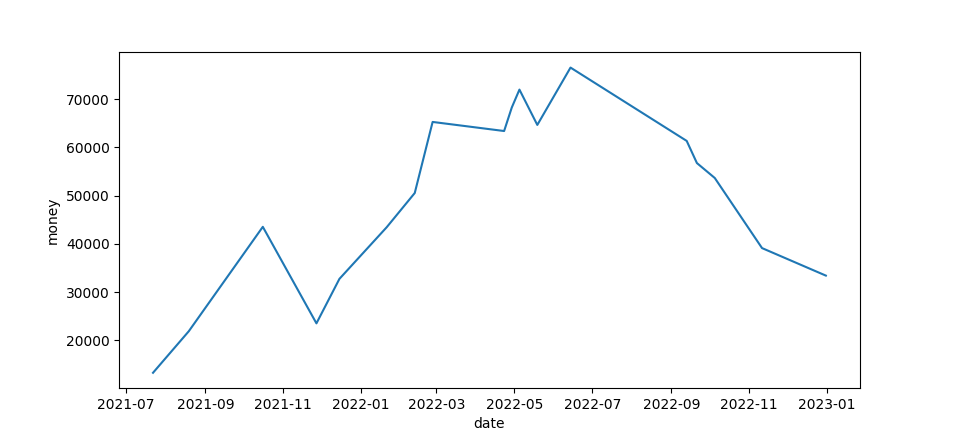

Total trades: 2075
Good trades: 1162 (56.00)%
Min Diff: $-639.00
Max Diff: $739.00
Min Pct. Change: -100.00%
Max Pct. Change: 255.56%


,id,money,price,options,days_to_expire,diff,pct_change
count,4150.0,4150.0,4150.0,4150.0,4150.0,2479.0,2479.0
mean,5.628080238810965e+16,36035.008674698794,239.22602409638554,47.040240963855425,42.98772048192771,-0.8709156918112142,-0.9366179518509559
std,5.244264103459449e+18,16901.26520745839,197.91226683203044,28.83906308037466,9.026544180355145,187.3446977957469,67.28438224526198
min,-9.221343847089128e+18,48.0,0.0,0.0,30.04,-639.0,-100.0
25%,-4.4117551286960625e+18,24644.75,89.0,24.0,36.0,-117.0,-56.666666666666664
50%,1.1140443168363555e+17,34732.5,176.0,41.0,43.0,-32.0,-50.140845070422536
75%,4.752631672379823e+18,49721.0,349.75,74.0,51.0,116.5,63.022000830220016
max,9.219903857636358e+18,76536.0,1193.0,100.0,59.04,739.0,255.55555555555554


In [158]:
df_trades = pd.DataFrame(trade_data)
# df_trades = df_trades.loc[df_trades["type"] == "call"]

df_trades["diff"] = df_trades.groupby("id")["price"].diff()
df_trades["pct_change"] = df_trades.groupby("id")["price"].pct_change() * 100

field_to_plot = "money"
# df_trades_plot = df_trades_plot.copy()
# df_trades_plot = df_trades.loc[(df_trades["side"] == "sell")]
df_trades_plot = df_trades.loc[(df_trades["side"] == "sell") & (df_trades["options"] == 0)]

# field_to_plot = "options"
# df_trades_plot = df_trades.groupby(["date"]).max("options").reset_index()

fig = figure(figsize=(13, 4), dpi=80)

plt.close(fig)
plt.clf()
plt.plot(pd.to_datetime(df_trades_plot["date"]), df_trades_plot[field_to_plot])
plt.xlabel("date")
plt.ylabel(field_to_plot)
plt.show()

total_trades = len(df_trades.loc[df_trades["side"] == "sell"])
good_trades = (df_trades.dropna()["diff"] > 0).sum()
print(f"Total trades: {total_trades}")
print(f"Good trades: {good_trades} ({good_trades/total_trades*100:.2f})%")
print(f"Min Diff: ${df_trades['diff'].min():.2f}")
print(f"Max Diff: ${df_trades['diff'].max():.2f}")
print(f"Min Pct. Change: {df_trades['pct_change'].min():.2f}%")
print(f"Max Pct. Change: {df_trades['pct_change'].max():.2f}%")
df_trades.describe().astype(str)